In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-20 04:02:56.306237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 04:02:56.306268: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('colheitas_sex.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('sex').resample('M').sum()

In [4]:
df

nr
sex       date            
feminino  1999-01-31  1959
          1999-02-28  1767
          1999-03-31  2725
          1999-04-30  2246
          1999-05-31  4080
...                    ...
masculino 2019-08-31  7618
          2019-09-30  8280
          2019-10-31  9221
          2019-11-30  8768
          2019-12-31  8830

[504 rows x 1 columns]

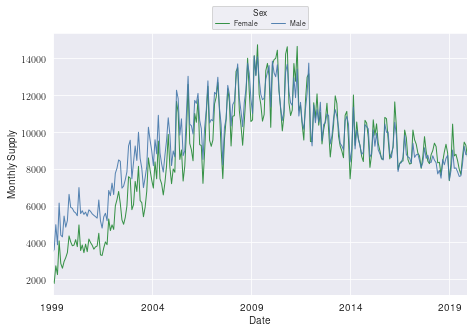

In [6]:
df.pivot_table(values="nr",index="date",columns="sex").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[2], colors[0]], xlabel='Date', ylabel='Monthly Supply')
plt.legend(['Female', 'Male'], title_fontsize='small', fontsize='x-small', title='Sex', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/supply_monthly_sex.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [6]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [7]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [8]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [9]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [20]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [23]:
df1 = df.pivot_table('nr', 'date', 'sex')
df1['Total'] = df1.sum(axis=1)

In [24]:
dataset = df1[['feminino','masculino']].values
dataset = df1[['feminino','masculino']].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae, rmse, smape = train_predict(dataset[:216], dataset_total[:216], dataset[216:], df1[['Total']][216:].values)

Epoch 1/500
7/7 [==============================] - 2s 7ms/step - loss: 0.5055
Epoch 2/500
7/7 [==============================] - 0s 9ms/step - loss: 0.4306
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.3181
Epoch 4/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1909
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 0.1144
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0989
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0960
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0911
Epoch 9/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0900
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0855
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0854
Epoch 12/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0825
Epoch 13/500
7/7 [==============================] - 0s 7ms/st

7/7 [==============================] - 0s 13ms/step - loss: 0.0646
Epoch 206/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0649
Epoch 207/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0621
Epoch 208/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0618
Epoch 209/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0634
Epoch 210/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0631
Epoch 211/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0619
Epoch 212/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0623
Epoch 213/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0624
Epoch 214/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0625
Epoch 215/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0635
Epoch 216/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0659
Epoch 217/500
7/7 [==============================] 

7/7 [==============================] - 0s 10ms/step - loss: 0.0603
Epoch 308/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0610
Epoch 309/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0600
Epoch 310/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0609
Epoch 311/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0621
Epoch 312/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0619
Epoch 313/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0602
Epoch 314/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0601
Epoch 315/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0601
Epoch 316/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0610
Epoch 317/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0617
Epoch 318/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0595
Epoch 319/500
7/7 [==============================] 

### Calculate Error

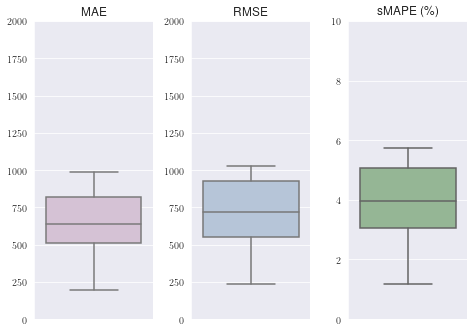

In [28]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 2000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 2000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
plt.savefig('figures/supply_lstm_monthly_sex_boxplot.pdf')

In [27]:
supply_lstm_month_sex = [mae,rmse,smape]
%store supply_lstm_month_sex 

Stored 'supply_lstm_month_sex' (list)
